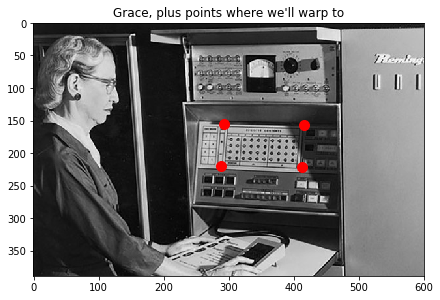

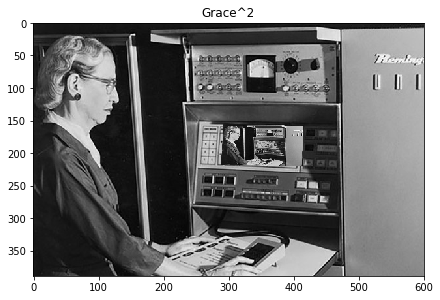

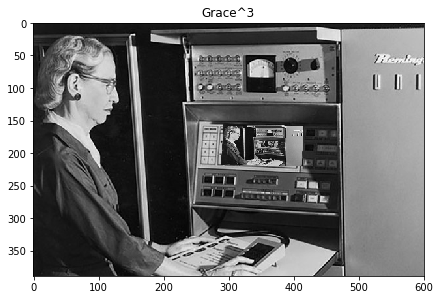

In [0]:
#David Fouhey
#Geometric Transformations
#UMich EECS 442 Fall 2019

from math import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

def ensureGrace():
  #ensure a copy of the grace hopper image is in the current directory
  if not os.path.exists("grace_600.png"):
    !wget http://web.eecs.umich.edu/~fouhey/misc/grace_600.png
    #If local, run this instead
    #os.system("wget http://web.eecs.umich.edu/~fouhey/misc/grace_600.png")

#images are tiny otherwise
plt.rcParams['figure.figsize'] = [7, 7]


####
#Helper functions for defining matrices
def eyeij(i,j,v):
  #return I but with I[i,j] = v 
  H = np.eye(3); H[i,j] = v
  return H

#scale and translation matrices
scaleX = lambda scx: eyeij(0,0,scx)
scaleY = lambda scy: eyeij(1,1,scy)
transX = lambda tx: eyeij(0,2,tx)
transY = lambda ty: eyeij(1,2,ty)

def rot2d(theta):
  #in-plane rotation
  H = np.eye(3)
  H[0,:2] = (np.cos(theta), -np.sin(theta))
  H[1,:2] = (np.sin(theta), np.cos(theta))
  return H

def perspect(px,py):
  #set the x/y perspective bits in the bottom
  H = np.eye(3)
  H[2,:2] = px, py
  return H

def matrixChain(L):
  #chain matrices together
  H = np.eye(3)
  for Hi in L:
    H = np.dot(H,Hi)
  return H
####

def applyH(H,P2D):
  #make P2D homogeneous
  PHomogeneous = np.hstack([P2D,np.ones((P.shape[0],1))])
  #apply H
  PX = np.dot(H,PHomogeneous.T).T
  #return back to normal points
  return PX[:,:2] / np.expand_dims(PX[:,-1],axis=1)

def showpoints(P,title=""):
  #Note the axis flip -- if you're looking at points and pictures, remember that
  #the top left is (0,0)!
  plt.figure(12)
  plt.scatter(P[:,0],P[:,1],60,np.array(range(P.shape[0])),cmap='jet')
  plt.axis('equal'); 
  plt.xlim([0,600]); plt.ylim([0,400])
  plt.gca().invert_yaxis()
  if title:
    plt.title(title)
  plt.show()

  

if __name__ == "__main__":
  
  ensureGrace()
  grace = np.array(Image.open("grace_600.png").convert('L')).astype(np.float)
  
  option = "graceinmiddle"
  
  if option == "pointsandimage":
    sx, sy, size = 200, 100, 200
    X, Y = np.meshgrid(np.linspace(sx,sx+size,10)[1:-1],np.linspace(sy,sy+size,10)[1:-1])
    P = np.column_stack([X.ravel(),Y.ravel()])
  
    showpoints(P,"Points")
  
    HMatrix = matrixChain([transY(-100),transX(300),rot2d(np.pi/4),mildpersp(1e-5,4e-4)])
    #HMatrix = perspect(1e-3,0)
    #HMatrix = transX(-30) / 5
    print(HMatrix)
  
    PXF = applyH(HMatrix,P)
    showpoints(PXF,"Warped Points")
  
    graceWarp = cv2.warpPerspective(grace,HMatrix,(grace.shape[1],grace.shape[0]))
  
    plt.figure()
    plt.imshow(grace,cmap='gray',vmin=0,vmax=255)
    plt.title("Original Grace")
    
    plt.figure()
    plt.imshow(graceWarp,cmap='gray',vmin=0,vmax=255)
    plt.title("Warped Grace")
    
  elif option == "graceinmiddle":
    
    #points for the corners of the image and the middle of the panel
    srcX, srcY = np.array([0,0,600,600]), np.array([0,400,0,400])
    targetX, targetY = np.array([292,288,415,412]), np.array([155,220,157,222])
    src = np.column_stack([srcX,srcY])
    target = np.column_stack([targetX,targetY])
    
    #show grace
    plt.figure()
    plt.title("Grace, plus points where we'll warp to")
    plt.imshow(grace,cmap='gray',vmin=0,vmax=255)
    plt.scatter(targetX,targetY,100,'r')
    
    #fit homography from image to panel, ignore other return of findHomography
    H,_ = cv2.findHomography(src,target)

    #warp grace, plus a mask of ones; where it's one, it's a pixel we made, where
    #it's zero it's a fill value
    graceWarp = cv2.warpPerspective(grace,H,(grace.shape[1],grace.shape[0]))
    graceWarpMask = cv2.warpPerspective(np.ones(grace.shape),H,(grace.shape[1],grace.shape[0]))
    
    #use the mask to only add grace where we warped and not the black background
    graceWarpAdd = (graceWarpMask) * graceWarp + (1-graceWarpMask) * grace
    
    plt.figure()
    plt.title("Grace^2")
    plt.imshow(graceWarpAdd,cmap='gray',vmin=0,vmax=255)
    
    #warp what we got, again, then add it 
    grace2Warp = cv2.warpPerspective(graceWarpAdd,H,(grace.shape[1],grace.shape[0]))
    grace2WarpAdd = (graceWarpMask) * grace2Warp + (1-graceWarpMask) * grace
    
    plt.figure()
    plt.title("Grace^3")
    plt.imshow(grace2WarpAdd,cmap='gray',vmin=0,vmax=255)
    
    